# Process results of T1.1

In [1]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

In [2]:
query_fields = ["kingdom", "phylum", "family", "genus", "specificepithet", "country", "stateprovince", "county"]

def count_item(values, item):
    counts = dict(Counter(values).most_common())
    return counts[item] if item in counts else 0

def make_id(df):
    return df.apply(lambda r: hash("".join([str(v) for v in r.values]).lower()), axis=1)

def get_results(presence, absence, absence_valid=""):
    global query_fields
    p_results = pd.read_csv(open(presence), sep="\t")
    a_results = pd.read_csv(open(absence, "r"), sep="\t")

    p_results["target"] = 1
    a_results["target"] = -1

    if absence_valid != "":
        a_results["valid"] = pd.read_csv(open(absence_valid, "r"), sep="\t", index_col=0)["valid"]
        p_results["valid"] = True

    df = pd.concat([p_results, a_results])

    df["query id"] = make_id(df[query_fields])

    df["scores"] = df["responses"].apply(lambda r: count_item(r.lower().split(), "yes"))
    df["yesnos"] = df["responses"].apply(lambda r: count_item(r.lower().split(), "yes") + count_item(r.lower().split(), "no"))
    df["abstains"] = 10 - df["yesnos"]

    df["prediction"] = df["scores"].apply(lambda x: -1 if x == 0 else 1) #.apply(lambda x: min(1, max(-1, x)))
    df["correct"] = df["prediction"] * df["target"]

    return df

In [6]:
t1_1[t1_1["target"] == 1].groupby("kingdom").size()

kingdom
animalia    3361
fungi       1976
plantae     4667
dtype: int64

In [3]:
unused_fields = ["query", "responses", "input token count", "output token count"]

df = get_results("results/t1-1-presence.tsv", "results/t1-1-absence.tsv", "processed/t1-1-absence-valid.tsv").groupby("query id").head(1).drop(columns=unused_fields)
t1_1 = df

# Might still have some absence queries identical to presence queries
df = get_results("results/t1-2-presence.tsv", "results/t1-2-absence.tsv").drop(columns=unused_fields)
df["phrasing"] = df["question number"] % 6
df["response id"] = make_id(df[["query id", "phrasing"]])
df = df.groupby("response id").head(1)
t1_2 = df

In [4]:
t1_1[t1_1["target"] == -1]

,kingdom,phylum,family,genus,specificepithet,country,stateprovince,county,target,valid,query id,scores,yesnos,abstains,prediction,correct
0,animalia,annelida,nereididae,Nereis,vexillosa,United States,Michigan,Keweenaw County,-1,True,-2188911228371084556,0,10,0,-1,1
1,animalia,annelida,nereididae,Nereis,succinea,United States,Missouri,Polk,-1,True,-3509767663995984420,0,10,0,-1,1
2,animalia,annelida,nereididae,Neanthes,arenaceodentata,United States,Alabama,Houston,-1,True,1117177469040390712,0,10,0,-1,1
3,animalia,annelida,nereididae,Nereis,pelagica,United States,Minnesota,Beltrami,-1,True,6072257759585618665,0,10,0,-1,1
4,animalia,annelida,nereididae,Alitta,succinea,United States,Kansas,Scott,-1,True,-5735761049532359168,8,10,0,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999,plantae,tracheophyta,poaceae,Dactylis,glomerata,United States,West Virginia,Wood,-1,True,-4235434535780205511,10,10,0,1,-1
10000,plantae,tracheophyta,poaceae,Poa,alpina,Papua New Guinea,Milne Bay,Samarai-Murua,-1,True,-8281763221185245895,0,5,5,-1,1
10001,plantae,tracheophyta,poaceae,Phalaris,arundinacea,United States,Illinois,Peoria,-1,False,384429529559101355,10,10,0,1,-1
10002,plantae,tracheophyta,poaceae,Bromus,carinatus,Mexico,Yucatan,Tizimin,-1,True,5914780407009674762,0,9,1,-1,1


In [5]:
t1_2[t1_2["target"] != 0].groupby(["phrasing"])["correct"].mean()

phrasing
0    0.207144
1    0.228315
2    0.102493
3    0.147243
4    0.131189
5    0.239151
Name: correct, dtype: float64

In [7]:
t1_3 = get_results("results/t1-3-presence-0-999-answer.tsv", "results/t1-3-absence-0-999-answer.tsv")

In [9]:
kpfg_scores = pd.read_csv(open("../../../analysis/results/kpfg_scores.tsv", "r"), sep="\t")
kpfg_scores["accuracy"] = (1 + kpfg_scores["num_correct"]) / (2 + kpfg_scores["num_response"])
kpfg_scores = kpfg_scores.set_index(["subject rank", "taxon"])
kpfg_scores.head(2)

num_correct  num_response  accuracy
subject rank taxon                                               
family       acaulosporaceae         31.0          36.0  0.842105
             acroporidae             40.0          40.0  0.976190

In [10]:
phrasing_avg_pred = t1_2.groupby("query id")["prediction"].mean()
phrasing_var_score = t1_2.groupby("query id")["scores"].var()
record_counts_by_taxon = pd.read_csv(open("processed/taxon-counts.tsv", "r"), sep="\t").set_index(["kingdom", "phylum", "family"])

In [11]:
def get_ums(instance):
    # TODO: condition um3 on prediction?
    um5 = record_counts_by_taxon.loc[instance["kingdom"], instance["phylum"], instance["family"]]
    um1_present = instance["scores"]
    um1_absent = 1 if um1_present == 0 else 0

    return pd.Series({
        "um1_present": um1_present,
        "um1_absent": um1_absent,
        "um1_either": um1_present + um1_absent,
        "um2": 1.0 - instance["abstains"] / 10.0,
        "um3_kingdom": acc_by_rank["kingdom"][instance["kingdom"]],
        "um3_phylum": acc_by_rank["phylum"][instance["phylum"]],
        "um3_family": acc_by_rank["family"][instance["family"]],
        "um3_country": acc_by_country[instance["country"]],
        "um3_stateprovince": acc_by_country[instance["country"]],
        "um4_agreement": phrasing_avg_pred[instance["query id"]] * -instance["prediction"],
        "um4_score_var": phrasing_var_score[instance["query id"]],
        "um5_kingdom": um5["kingdomCount"],
        "um5_phylum": um5["phylumCount"],
        "um5_family": um5["familyCount"],
        "um6_phylum": kpfg_scores["accuracy"]["phylum"][instance["phylum"].lower()],
        "um6_family": kpfg_scores["accuracy"]["family"][instance["family"].lower()],
        "um6_genus": kpfg_scores["accuracy"]["genus"][instance["genus"].lower()],
        "um7_phylum": kpfg_scores["num_response"]["phylum"][instance["phylum"].lower()] / 10,
        "um7_family": kpfg_scores["num_response"]["family"][instance["family"].lower()] / 40,
        "um7_genus": kpfg_scores["num_response"]["genus"][instance["genus"].lower()] / 50,
    })

In [12]:
df = t1_1
df = df[df["correct"] != 0]

def get_acc_by_field(d, field, smoothing=1):
    num_records = d.groupby(field).size()
    num_correct = smoothing + d[d["correct"] == 1].groupby(field).size().reindex(num_records.index).fillna(0)
    num_incorrect = smoothing + d[d["correct"] == -1].groupby(field).size().reindex(num_records.index).fillna(0)
    return num_correct / (num_correct + num_incorrect)

acc_by_rank = pd.Series({rank: get_acc_by_field(df, rank) for rank in ["kingdom", "phylum", "family"]})
acc_by_country = get_acc_by_field(df, "country")
acc_by_stateprovince = get_acc_by_field(df, "stateprovince")

train_df = pd.concat([df.apply(lambda row: get_ums(row), axis=1), df], axis=1)
# train_df = train_df[train_df["correct"] != 0]
# train_df["correct"] = (train_df["correct"] + 1).floordiv(2)

In [2692]:
t1_1[t1_1["valid"]].groupby("target")["correct"].mean() * .5 + .5

target
-1    0.668014
 1    0.573770
Name: correct, dtype: float64

In [2690]:
t1_1.groupby("target")["correct"].mean() * .5 + .5

target
-1    0.640145
 1    0.573770
Name: correct, dtype: float64

In [2787]:
t1_1.groupby("kingdom")["correct"].mean() * .5 + .5

kingdom
animalia    0.627591
fungi       0.526075
plantae     0.628052
Name: correct, dtype: float64

In [30]:
train_kingdoms = [
    # "animalia",
    "plantae",
    # "fungi"
]
    
test_kingdoms = [
    "animalia",
    "plantae",
    "fungi"
]

test_fraction = .5

features = [
    "um1_present", # um1: scores
    "um1_absent",
    "um1_either",
    "um2", # um2: number of abstains
    "um3_kingdom", # um3: accuracy by field values
    "um3_phylum",
    # 'um3_family',
    "um3_country",
    "um3_stateprovince",
    "um4_agreement", # Variance in scores with phrasing changes
    "um4_score_var",
    'um5_kingdom', # um5: iDigBio record counts by taxonomic ranks
    'um5_phylum',
    'um5_family',
    "um6_phylum", # Accuracy on taxonomy questions
    "um6_family",
    "um6_genus",
    "um7_phylum", # Number of yes-no responses to taxonomy questions
    "um7_family",
    "um7_genus",
]

predictions = {
    -1,
     1
}

only_valid_absences = True

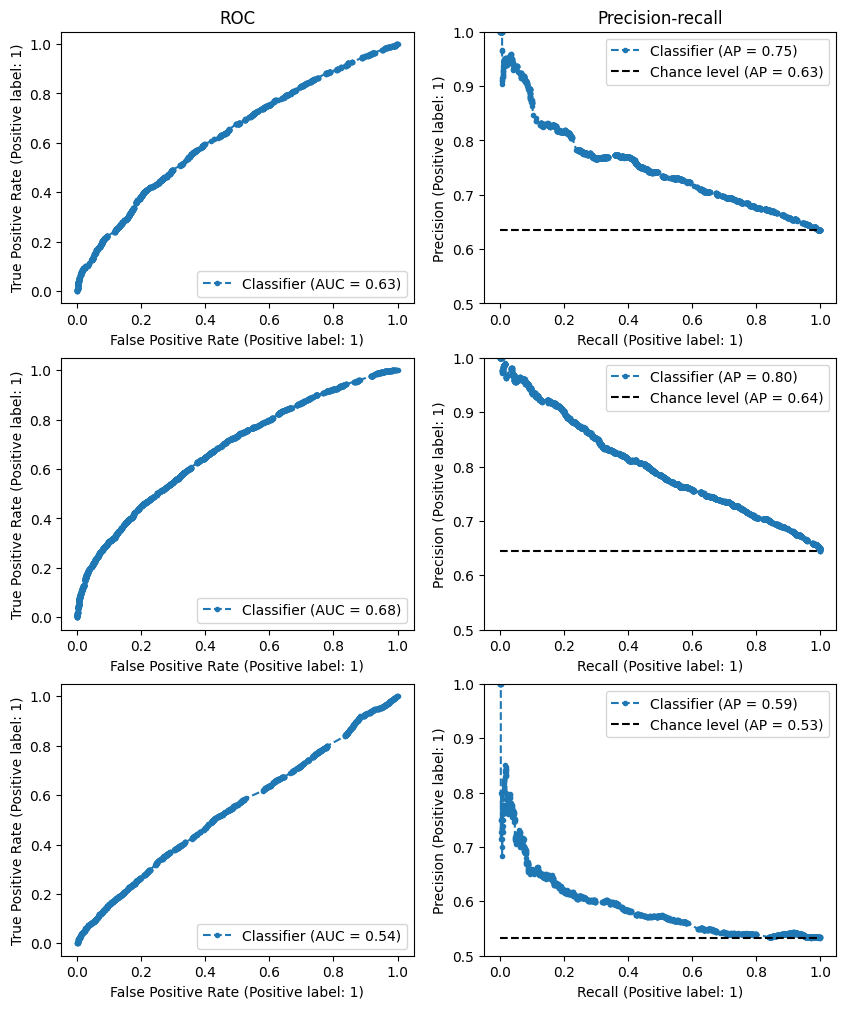

In [31]:
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
roc_args = {"marker":".", "linestyle":"--"}

if only_valid_absences and "valid" in train_df:
    tdf = train_df[train_df["valid"]]
else:
    tdf = train_df

if len(train_kingdoms) > 0:
    train_set = tdf[tdf["kingdom"].isin(train_kingdoms)]
    test_set = tdf[tdf["kingdom"].isin(test_kingdoms)]
else:
    train_set, test_set = train_test_split(
        tdf[tdf["kingdom"].isin(test_kingdoms) * tdf["prediction"].isin(predictions)],
        test_size=test_fraction
    )


xgboost = HistGradientBoostingClassifier(
    loss='log_loss',
    # early_stopping=True,
    min_samples_leaf=1,
    max_iter=100,
    monotonic_cst=np.ones_like(features, dtype=int)
).fit(train_set[features], train_set["correct"]) # categorical_features=["stateprovince"]

# get_ums(instance)[features].to_frame().transpose()
# probs = np.random.uniform(0, 1, len(test_set))
# probs = np.column_stack((probs, 1 - probs))
# probs = xgboost.predict_proba(test_set[features])

k = test_kingdoms
f, axes = plt.subplots(len(k), 2, figsize=(10, 4 * len(k)))

if len(k) == 1:
    axes = [axes]

axes[0][0].title.set_text(f"ROC")
axes[0][1].title.set_text(f"Precision-recall")

for i, ik in enumerate(k):
    ts = test_set[test_set["kingdom"] == ik]
    probs = xgboost.predict_proba(ts[features])
    RocCurveDisplay.from_predictions(ts["correct"], probs[:,1], ax=axes[i][0], **roc_args);
    display = PrecisionRecallDisplay.from_predictions(
        ts["correct"], probs[:,1], plot_chance_level=True, drop_intermediate=True, ax=axes[i][1], drawstyle="default", **roc_args
    )
    axes[i][1].set_ylim(0.5, 1)
    axes[i][1].legend()
plt.show()

In [2809]:
t1_1[t1_1["kingdom"] == "fungi"]["phylum"].value_counts()

phylum
ascomycota         1187
basidiomycota      1186
chytridiomycota     580
zygomycota          337
cyanobacteria       237
glomeromycota       236
fungi               168
Name: count, dtype: int64

In [2795]:
ts[ts["confidence"] > .7]["family"].value_counts()

family
asteraceae          468
fabaceae            399
poaceae             300
holothuriidae       263
caulerpaceae        235
cricetidae          227
myrtaceae           184
plethodontidae      165
ulvaceae            113
apidae              104
cyprinidae          100
rhodomelaceae        97
acroporidae          88
cladoniaceae         82
parmeliaceae         75
unionidae            67
agaricaceae          65
formicidae           64
faviidae             63
sphagnaceae          62
muricidae            62
dicranaceae          62
nereididae           50
corallinaceae        47
amphiuridae          46
plexauridae          41
cladophoraceae       39
polyporaceae         38
veneridae            34
microcionidae        29
carabidae            26
orchidaceae          25
physciaceae          25
scapaniaceae         23
halichondriidae      22
ophiuridae           21
pottiaceae           19
spiriferidae         19
lejeuneaceae         18
frullaniaceae        18
spionidae            16
ceramiace

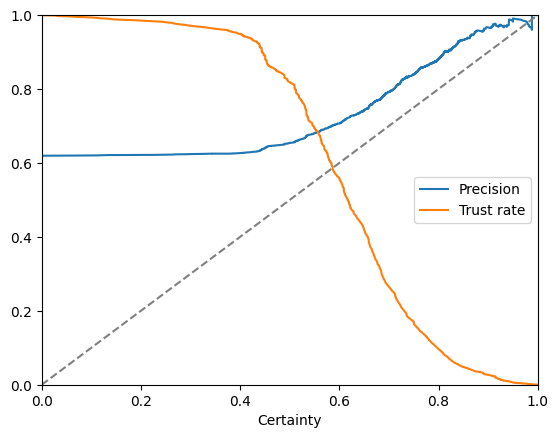

In [2788]:
ts = test_set.copy()
ts["certainty"] = xgboost.predict_proba(ts[features])[:,1]
ts["correct"] = ts["correct"].clip(0,1)
ts = ts.sort_values("certainty")

pd.DataFrame({
    "Certainty": ts["certainty"],
    "Precision": [ts[ts["certainty"] >= c]["correct"].mean() for c in ts["certainty"]],
    "Trust rate": [ts[ts["certainty"] >= c].index.size / ts.index.size for c in ts["certainty"]]
}).set_index("Certainty").plot()

# Well-calibrated reference line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [2789]:
conf_model = (
    "isotonic"
    # "logistic"
)
calibration_set = (
    train_set
    # test_set
)

Note - It would be better to calibrate on a subset, then test the calibration on the rest

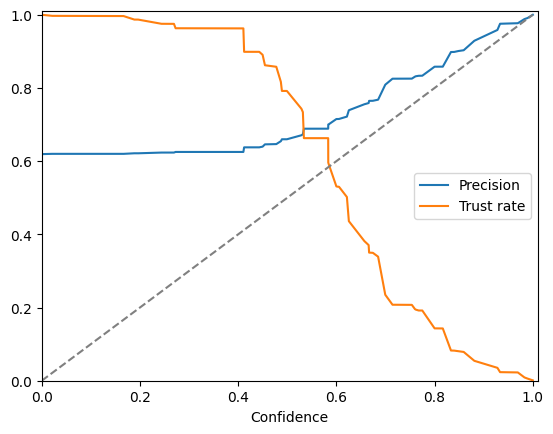

In [2790]:
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve

# Learn confidence function
rs = calibration_set.copy()
rs["certainty"] = xgboost.predict_proba(rs[features])[:,1]
rs["correct"] = rs["correct"].clip(0,1)
rs = rs.sort_values("certainty")

if conf_model == "isotonic":
    ir = IsotonicRegression(out_of_bounds="clip").fit(rs["certainty"].to_numpy(), rs["correct"].to_numpy())
    calibrate = lambda x: ir.transform(x) 
elif conf_model == "logistic":
    lr = LogisticRegression().fit(rs[["certainty"]].to_numpy(), rs["correct"].to_numpy())
    calibrate = lambda x: lr.predict_proba(x.reshape(-1, 1) if type(x) == np.ndarray else x.to_numpy().reshape(-1, 1))[:,1]
else:
    calibrate = lambda x: 0
    uh=oh

# Plot confidence vs. precision
ts["confidence"] = calibrate(ts["certainty"])

pd.DataFrame({
    "Confidence": ts["confidence"],
    "Precision": [ts[ts["confidence"] >= c]["correct"].mean() for c in ts["confidence"]],
    "Trust rate": [ts[ts["confidence"] >= c].index.size / ts.index.size for c in ts["confidence"]]
}).set_index("Confidence").plot()

# Well-calibrated reference line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlim(0, 1.01)
plt.ylim(0, 1.01)
plt.legend(loc="center right")
plt.show()

In [2791]:
calibration_args = {
    "n_bins": 100,
    "strategy": (
        # "uniform"
        "quantile"
    )
}

Certainty ECE: 0.0413177341502116
Confidence ECE: 0.03908100565993338


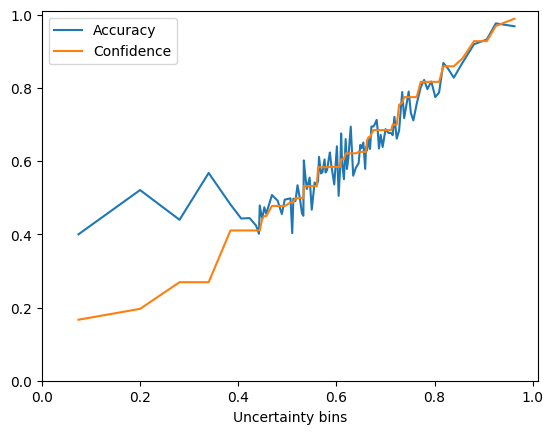

In [2792]:
args = calibration_args | { "pos_label": 1, "y_true": ts["correct"] }
cert_prob_true, cert = calibration_curve(y_prob=ts["certainty"], **args)
conf_prob_true, conf = calibration_curve(y_prob=ts["confidence"], **args)

print("Certainty ECE:", abs(cert - cert_prob_true).sum() / len(cert))
print("Confidence ECE:", abs(conf - conf_prob_true).sum() / len(conf))

plt.plot(cert, cert_prob_true, label="Accuracy")
plt.plot(cert, calibrate(cert), label="Confidence")
plt.xlabel("Uncertainty bins")
plt.xlim([0,1.01])
plt.ylim([0,1.01])
plt.legend()
plt.show()

In [ ]:
ts[ts["confidence"] < .4]

array([[<Axes: title={'center': 'certainty'}>,
        <Axes: title={'center': 'confidence'}>]], dtype=object)

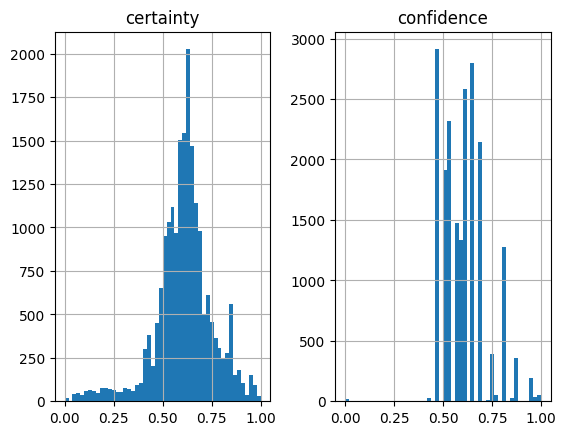

In [2638]:
ts[["certainty", "confidence"]].hist(bins=50)

In [2446]:
ts[ts["confidence"] > 0.8]["target"].value_counts()

target
 1    93
-1    84
Name: count, dtype: int64

In [2449]:
ts[ts["target"] == 1]["correct"].value_counts()

correct
0    356
1    346
Name: count, dtype: int64

<Axes: >

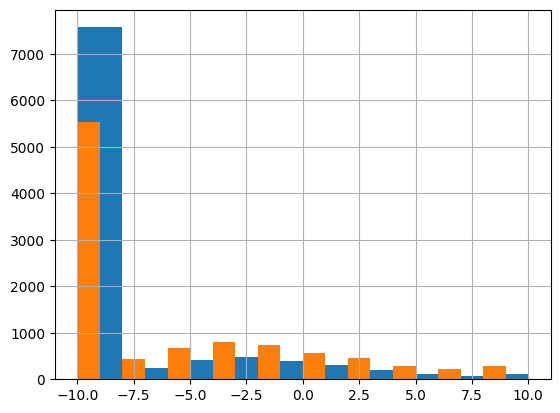

In [2328]:
t = t1_2[t1_2["phrasing"] == 0]
t[t["target"] == -1]["scores"].hist()
t[t["target"] == 1]["scores"].hist(width=1)

<Axes: >

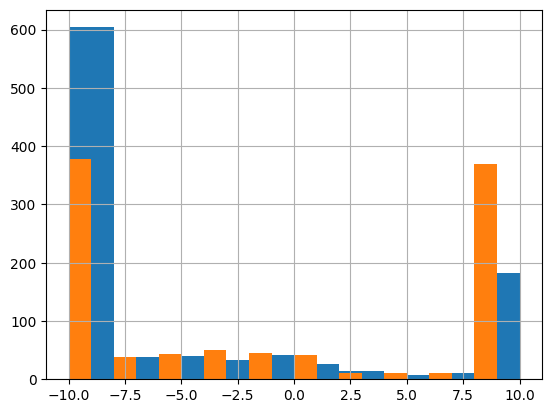

In [188]:
t1_3[t1_3["target"] == -1]["scores"].hist()
t1_3[t1_3["target"] == 1]["scores"].hist(width=1)